In [1]:
from HF_helper import HF_tools
import numpy as np

In [2]:
HF=HF_tools()

In [3]:
def eigenval(X):
    eigenValues, eigenVectors = np.linalg.eig(X)
    idx = eigenValues.argsort()    
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return eigenValues,eigenVectors


def update_F(HF):

    for i in range(HF.K):
        for j in range(HF.K):
            CX=0
            for k in range(HF.K):
                for l in range(HF.K):
                    CX += HF.P[k,l]*(HF.G[i,j,k,l]   -0.5*HF.G[i,k,j,l]) ; 

            HF.F[i,j]=HF.T[i,j]+HF.A[i,j]+CX
    

def solve_F(HF):
    Fp=np.matmul(HF.S_inv_sqrt,HF.F)
    Fp=np.matmul(Fp,HF.S_inv_sqrt)
    eig,eigV=eigenval(Fp)
    HF.C=np.matmul(HF.S_inv_sqrt,eigV)
    HF.E=eig




In [4]:
for s in range(1000):
    update_F(HF)
    solve_F(HF)
    HF.set_P_ij()
    Etot=HF.get_total_E()
    print(HF.E[0],Etot)



-2.211979733335863 -4.423959466671725
-1.3299287992050692 -3.530327311686287
-1.3620503655301477 -3.5580844720267946
-1.367023474340363 -3.5623283339887197
-1.367766941078093 -3.562961226798113
-1.3678778335829145 -3.563055590156524
-1.3678943698208477 -3.56306966076036
-1.3678968356126504 -3.5630717588723666
-1.3678972032959524 -3.5630720717291755
-1.367897258122524 -3.5630721183803624
-1.367897266297909 -3.5630721253366877
-1.3678972675169698 -3.56307212637397
-1.367897267698748 -3.5630721265286436
-1.3678972677258536 -3.563072126551707
-1.3678972677298957 -3.563072126555147
-1.3678972677304981 -3.5630721265556593
-1.367897267730588 -3.5630721265557344
-1.3678972677306018 -3.563072126555747
-1.3678972677306036 -3.5630721265557486
-1.3678972677306038 -3.563072126555749
-1.3678972677306038 -3.563072126555748
-1.367897267730604 -3.563072126555748
-1.367897267730604 -3.563072126555748
-1.367897267730604 -3.563072126555748
-1.367897267730604 -3.563072126555748
-1.367897267730604 -3.563072

In [5]:
from HF_helper_2 import BasisFunction, S_ab, V_ab, T_ab, TwoE
import numpy as np


In [6]:
#######
#H-He+
R_i=[[0,0,0],[0,0,1.5517]]
Z_i=[1.0,2.0]
N=2 #Number of electrons

#BASIS-SET
b_set=[]
b_set.append ( BasisFunction(origin=[0,0,0],shell=[0,0,0],exps=[0.4166],coefs=[1]) )
b_set.append ( BasisFunction(origin=[0,0,1.5517],shell=[0,0,0],exps=[0.7739],coefs=[1]) )
######


#H
R_i=[[0,0,0]]
Z_i=[1.0]
N=2 #Number of electrons

exps=[13.00773 ,1.962079, 0.444529, 0.1219492]
basis_set=[]
for a in exps:
    basis_set.append ( BasisFunction(origin=[0,0,0],shell=[0,0,0],exps=[a],coefs=[1]) )


M=len(basis_set)
index=range(M)

global F;F=np.zeros([M,M])
global T;T=np.zeros([M,M])
global S;S=np.zeros([M,M])
global V;V=np.zeros([M,M])
global J;J=np.zeros([M,M,M,M])
global K;K=np.zeros([M,M,M,M])
global P;P=np.zeros([M,M])
global C;C=np.zeros([M,M])
global eps;eps=np.zeros([M])

#One electron integrals
for a,basis_func_a in zip(index,b_set):
    for b,basis_func_b in zip(index,b_set):
        S[a,b]=S_ab(basis_func_a,basis_func_b)
        T[a,b]=T_ab(basis_func_a,basis_func_b)
        for R,Z in zip(R_i,Z_i):
            V[a,b] -= Z*V_ab(basis_func_a,basis_func_b,R)
        
#Two electron integrals
for a,basis_func_a in zip(index,b_set):
    for b,basis_func_b in zip(index,b_set):
        for c,basis_func_c in zip(index,b_set):
            for d,basis_func_d in zip(index,b_set):
                J[a,b,c,d]=TwoE(basis_func_a,basis_func_b,basis_func_c,basis_func_d)
                K[a,b,c,d]=TwoE(basis_func_a,basis_func_b,basis_func_c,basis_func_d)


#Construct "diagonilzer"
D,U =np.linalg.eig(S)
D=np.diag(1/D**0.5)
UD=np.matmul(U,D)
global X;X=np.matmul(UD,U.T)


In [7]:
def build_F():
    global F
    for i in range(M):
        for j in range(M):
            JK=0
            for k in range(M):
                for l in range(M):
                    JK += P[k,l]*(J[i,j,k,l]   -0.5*K[i,j,k,l]) 
            F[i,j]=T[i,j]+V[i,j]+JK 

def solve_F():
    global C
    global eps
    Fp=np.matmul(X,F)
    Fp=np.matmul(Fp,X)
    eps,eigV=eigenval(Fp)
    C=np.matmul(X,eigV)
    

def update():
    global P
    Pold=P
    Pnew=P*0.0
    for i in range(M):
        for j in range(M):
            for k in range(int(N/2)):
                Pnew[i,j] += 2*C[i,k]*C[j,k]

    P=0.8*Pold+0.2*Pnew
    
def get_total_E():
    total_E=0.0
    for i in range(M):
        for j in range(M):
            total_E += 0.5*P[i,j]*(T[i,j] +V[i,j] + F[i,j])
    return total_E
    
def eigenval(A):
    eigenValues, eigenVectors = np.linalg.eig(A)
    idx = eigenValues.argsort()    
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return eigenValues,eigenVectors


In [8]:
E=[]
for steps in range(20):
    build_F()
    solve_F()
    update()
    tot_E=get_total_E()
    E.append(tot_E)

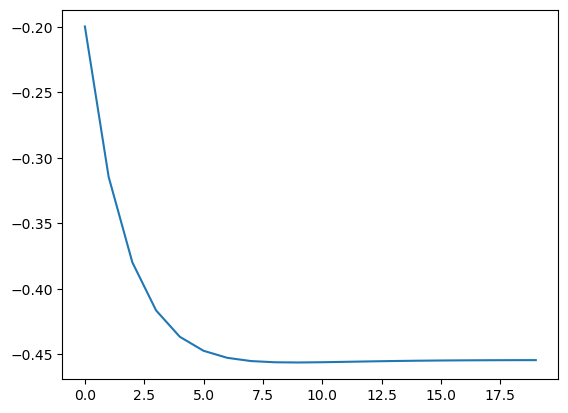

In [9]:
import matplotlib.pyplot as plt
plt.plot(E)


In [10]:
C

array([[ 0.01351701,  0.02997485,  0.00649147,  1.26082784],
       [ 0.11105787,  0.00876283, -1.48572509, -1.04244058],
       [ 0.19145519,  1.44748225,  1.54045388,  0.57417816],
       [ 0.79575696, -1.29149895, -0.59495028, -0.2045173 ]])

In [11]:
def txt2mat(A):

    A=A.split("\n")
    N=len(A)-2
    A_mat=np.zeros([N,N])


    i=0
    for a in A:
        if a != '':
            a=a.split(" ")
            j=0
            for aa in a:
                if aa != '':
                    A_mat[i,j]=float(aa)
                    j=j+1
            i+=1
    return A_mat


A='''
1.0 0.0 0.0
0.0 1.0 0.0
0.0 0.0 1.0
'''






ModuleNotFoundError: No module named 'pyscf'